In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.optimize

# Efficiency curve fit
- assume true trigger efficiency: $\varepsilon(E, t, \sigma_t, \varepsilon_0) = \frac{\varepsilon_0}{2}[1 + \mathrm{erf}(\frac{E-t}{\sigma_t})]$
	- $\varepsilon_0 = \{ 0.9, 0.95, 0.99 \}$ — asymptotic max efficiency
	- $t = 3~\mathrm{KeV}$ — detection threshold
	- $\sigma_t = 1~\mathrm{KeV}$ — step function smearing param
- take $20$ energy values $E_i = 1, 2, 3, ..., 20~\mathrm{KeV}$
- $\forall E_i$
	- generate $n = \{ 100, 1000, 10000 \}$ random values $\sim U(0, 1)$
	- count the number of values below $\varepsilon_i$
	- fit the data with binomial $\mathcal L$, Poisson $\mathcal L$ and $\chi^2$
- repeat for $10^3$ toy MC sets $\forall n, \varepsilon_0$
- plot the best-fit distribution of $\hat \varepsilon_0$ for all methods

In [2]:
from dataclasses import dataclass


@dataclass
class Estimations:
    binomial_like: float
    poisson_like: float
    chi2: float


def efficiency_curve_fit(
    n: int,
    eps_0: float,
    ax: plt.Axes | None = None,
    verbose: bool = False,
) -> Estimations:
    t = 3
    sigma_t = 1
    eta = lambda E: 0.5 * (1 + scipy.special.erf((E - t) / sigma_t))
    eps = lambda E: eps_0 * eta(E)

    # data generation
    E_min = 1
    E_max = 10
    E_i = np.linspace(E_min, E_max, 20)
    k_i = np.sum(
        np.random.uniform(0, 1, size=(len(E_i), n)) < np.expand_dims(eps(E_i), axis=1),
        axis=1,
    )

    # fitting
    minimize_kwargs = dict(
        # x0=[eps_0],
        x0=[0.5],
        bounds=scipy.optimize.Bounds([0], [1]),
        method="Powell",
        options={"disp": verbose},
    )
    k = np.sum(k_i)
    eta_i = eta(E_i)

    negloglike_binomial = lambda eps_0: -(
        k * np.log(eps_0) + np.sum((n - k_i) * np.log(1 - eps_0 * eta_i))
    )
    binL_fit = scipy.optimize.minimize(negloglike_binomial, **minimize_kwargs)
    if verbose:
        print("Binomial fit:", binL_fit.message, "eps = ", binL_fit.x)

    negloglike_poisson = lambda eps_0: np.sum(
        eps_0 * n * eta_i - k_i * np.log(eps_0 * n * eta_i)
    )
    poissL_fit = scipy.optimize.minimize(negloglike_poisson, **minimize_kwargs)
    if verbose:
        print("Poisson fit:", poissL_fit.message, "eps = ", poissL_fit.x)

    eps2fit = lambda E, eps_0: n * eps_0 * eta(E)
    chi2_popt, _ = scipy.optimize.curve_fit(
        eps2fit,
        E_i,
        k_i,
        p0=minimize_kwargs["x0"],
        # sigma=3 + np.sqrt(k_i),
    )
    if verbose:
        print("Chi2 fit: ", chi2_popt)

    if ax is not None:
        ax.errorbar(E_i, k_i / n, np.sqrt(k_i) / n, linestyle="none", marker="o")
        E_range = np.linspace(E_min, E_max, 300)
        ax.plot(E_range, eps(E_range), "k", label="True sens. curve")
        for eps_estimate, label, color in [
            (binL_fit.x[0], "Binomial $ \\mathcal{L} $", "r"),
            (poissL_fit.x[0], "Poisson $ \\mathcal{L} $", "b"),
            (chi2_popt[0], "$ \\chi^2 $ curve fit", "g"),
        ]:
            ax.plot(E_range, eps_estimate * eta(E_range), color=color, label=label)
        ax.axhline(1, linestyle="--", color="k")
        ax.axhline(0, linestyle="--", color="k")
        ax.legend()
    return Estimations(
        binomial_like=binL_fit.x[0],
        poisson_like=poissL_fit.x[0],
        chi2=chi2_popt[0],
    )

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_6390/1218367634.py:43: RuntimeWarning: divide by zero encountered in log
  k * np.log(eps_0) + np.sum((n - k_i) * np.log(1 - eps_0 * eta_i))


Optimization terminated successfully.
         Current function value: 556.211246
         Iterations: 2
         Function evaluations: 24
Binomial fit: Optimization terminated successfully. eps =  [0.9045851]
Optimization terminated successfully.
         Current function value: -4746.989111
         Iterations: 2
         Function evaluations: 63
Poisson fit: Optimization terminated successfully. eps =  [0.90917852]
Chi2 fit:  [0.90699758]


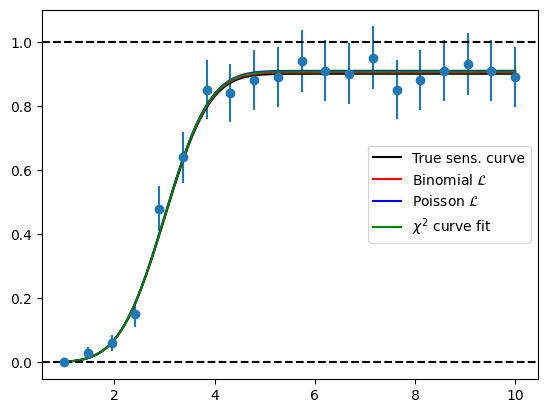

In [3]:
fig, ax = plt.subplots()

efficiency_curve_fit(n=100, eps_0=0.9, ax=ax, verbose=True)

plt.show()

  0%|          | 0/16000 [00:00<?, ?it/s]/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_6390/1218367634.py:43: RuntimeWarning: divide by zero encountered in log
  k * np.log(eps_0) + np.sum((n - k_i) * np.log(1 - eps_0 * eta_i))
/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_6390/1218367634.py:43: RuntimeWarning: invalid value encountered in multiply
  k * np.log(eps_0) + np.sum((n - k_i) * np.log(1 - eps_0 * eta_i))
100%|██████████| 16000/16000 [00:27<00:00, 578.69it/s]


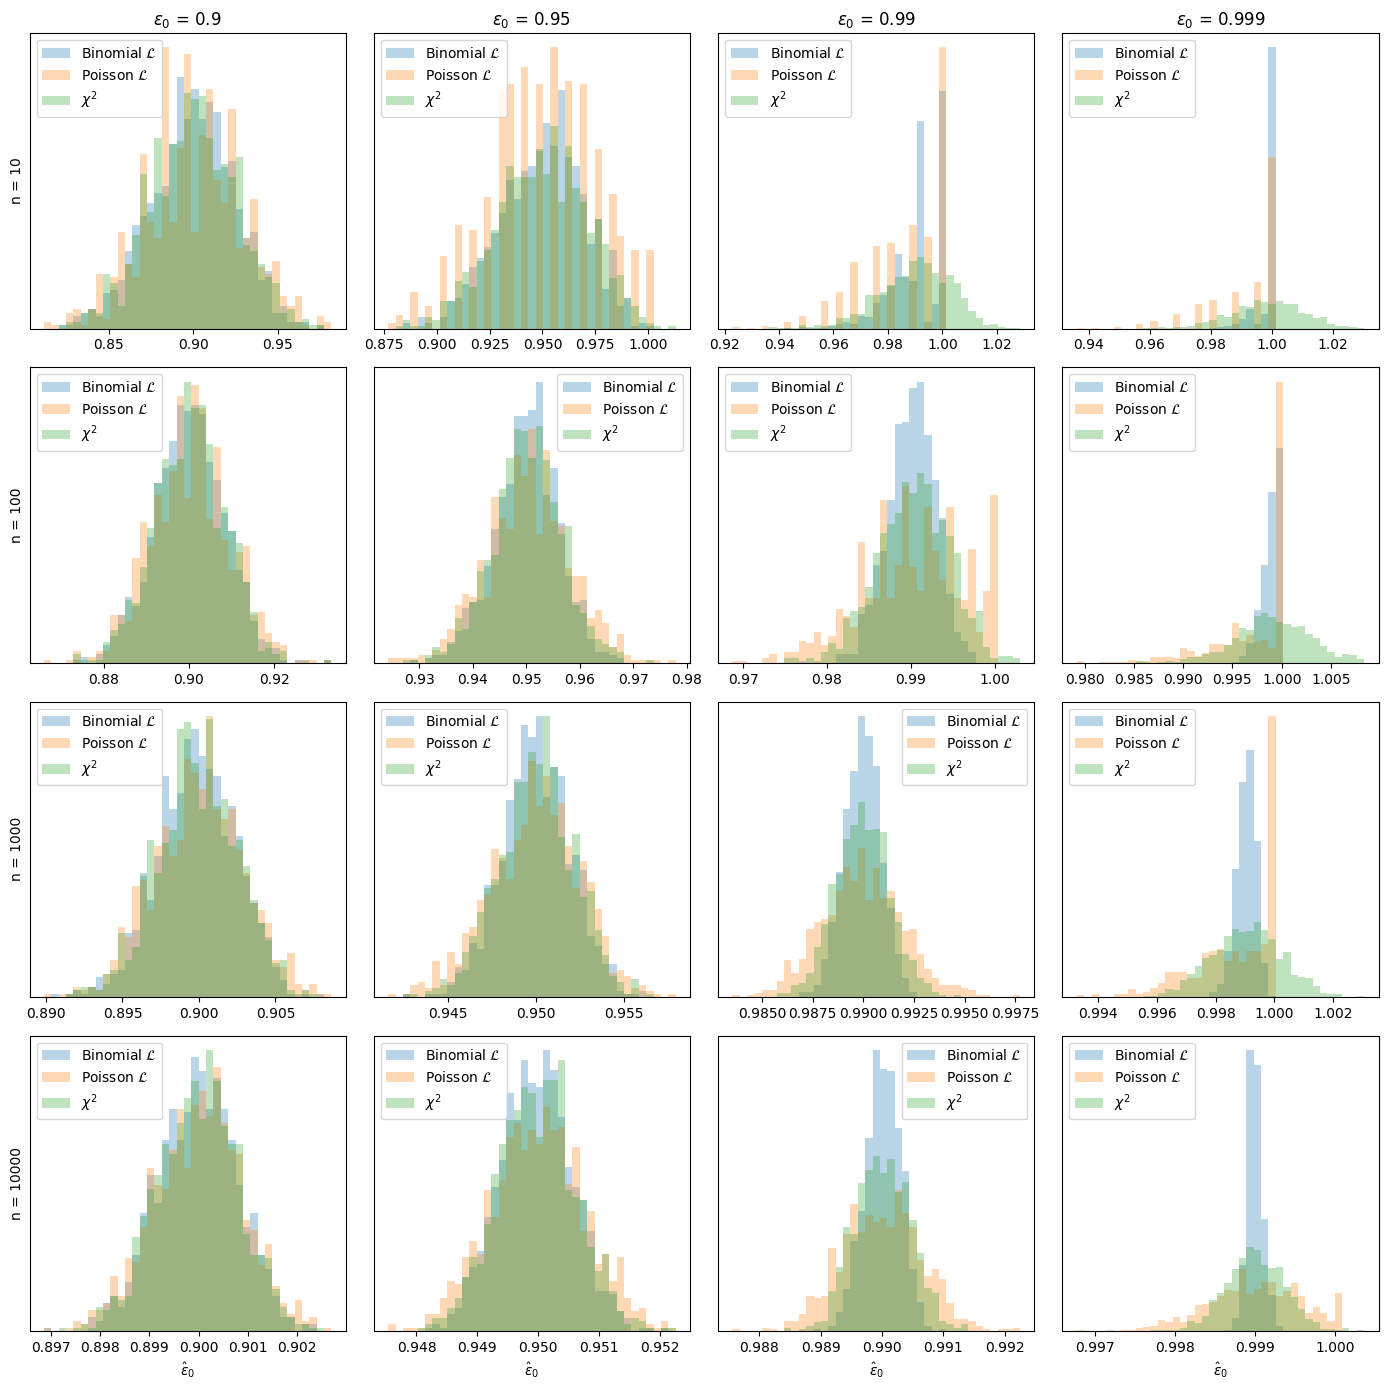

In [4]:
import itertools
from tqdm import tqdm

n_options = [10, 100, 1000, 10000]
eps0_options = [0.9, 0.95, 0.99, 0.999]
monte_carlo_sets = 1000

fig, axes = plt.subplots(
    nrows=len(n_options),
    ncols=len(eps0_options),
    figsize=(3.5 * len(eps0_options), 3.5 * len(n_options)),
)

with tqdm(total=len(n_options) * len(eps0_options) * monte_carlo_sets) as progress_bar:
    for n, ax_row in zip(n_options, axes):
        ax_row[0].set_ylabel(f"n = {n}")
        for eps0, ax in zip(eps0_options, ax_row):
            estimations : list[Estimations]= []
            for _ in range(monte_carlo_sets):
                progress_bar.update()
                estimations.append(efficiency_curve_fit(n, eps0))
            all_estimations = np.array(
                list(
                    itertools.chain.from_iterable(
                        [c.binomial_like, c.poisson_like, c.chi2] for c in estimations
                    )
                )
            )
            bins = np.linspace(all_estimations.min(), all_estimations.max(), 40)
            ax.hist(
                [e.binomial_like for e in estimations],
                alpha=0.3,
                bins=bins,
                label="Binomial $ \mathcal{L} $",
            )
            ax.hist(
                [e.poisson_like for e in estimations],
                alpha=0.3,
                bins=bins,
                label="Poisson $ \mathcal{L} $",
            )
            ax.hist(
                [e.chi2 for e in estimations],
                alpha=0.3,
                bins=bins,
                label="$ \\chi^2 $",
            )
            ax.legend()
            if n == n_options[0]:
                ax.set_title(f"$ \\varepsilon_0 $ = {eps0}")
            if n == n_options[-1]:
                ax.set_xlabel("$ \\hat \\epsilon_0 $")
            ax.set_yticks([])

plt.tight_layout()
plt.show()